# https://www.kaggle.com/datasets/programmerrdai/global-innovation-index-2008-2021

Data Source: https://unctadstat.unctad.org/datacentre/dataviewer/US.FTRI

In [159]:
#Import the relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


# Load the dataset
file_path = r"C:\Users\ZAPANTA\Downloads\AIM-MIB2025A-AIProject\AIM-MIB2025A-AIProject\FINAL Project\Global Innovation Index (2008-2021).csv"
gii_data = pd.read_csv(file_path)

# Pivot the data to get the desired structure
gii_pivot = gii_data.pivot_table(
    index=['Year', 'Economy Label'],
    columns='Category Label',
    values='Index'
).reset_index()

# Rename columns for clarity
gii_pivot.columns.name = None
gii_pivot.rename(columns={
    'Overall index': 'Overall Index',
    'ICT': 'ICT',
    'Skills': 'Skills',
    'Research and Development': 'Research and Development',
    'Industry activity': 'Industry Activity',
    'Access to finance': 'Access to Finance'
}, inplace=True)

gii_pivot.head()

,Year,Economy Label,Access to Finance,ICT,Industry Activity,Overall Index,Research and Development,Skills
0,2008,Afghanistan,0.4223,0.0941,0.4625,0.1363,0.0000,0.1646
1,2008,Albania,0.6995,0.2067,0.4718,0.3245,0.0342,0.4288
2,2008,Algeria,0.5257,0.1353,0.2735,0.2788,0.1978,0.4631
3,2008,Angola,0.6327,0.1946,0.2105,0.1543,0.0000,0.2244
4,2008,Argentina,0.5270,0.5657,0.6186,0.5492,0.2992,0.7160


In [160]:
# Drop the 'Year' column and then display summary statistics
summary_stats = gii_pivot.drop(columns=['Year']).describe()
summary_stats

,Access to Finance,ICT,Industry Activity,Overall Index,Research and Development,Skills
count,2320.000000,2320.000000,2317.000000,2317.000000,2320.000000,2320.000000
mean,0.659836,0.425499,0.552936,0.451235,0.242022,0.455386
std,0.175083,0.267091,0.191647,0.265374,0.238267,0.237266
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.543450,0.183300,0.411600,0.224500,0.049800,0.256950
50%,0.676650,0.392350,0.545800,0.413600,0.158800,0.449650
75%,0.791950,0.639950,0.703000,0.642000,0.400875,0.626900
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [161]:
# Check for missing values in 'Industry Activity' and 'Overall Index'
missing_industry_activity = gii_pivot_imputed[gii_pivot_imputed['Industry Activity'].isna()]
missing_overall_index = gii_pivot_imputed[gii_pivot_imputed['Overall Index'].isna()]

# Display the rows with missing values in 'Industry Activity'
print("Rows with missing values in 'Industry Activity':")
print(missing_industry_activity)

# Display the rows with missing values in 'Overall Index'
print("Rows with missing values in 'Overall Index':")
print(missing_overall_index)

Rows with missing values in 'Industry Activity':
Empty DataFrame
Columns: [Year, Economy Label, Access to Finance, ICT, Industry Activity, Overall Index, Research and Development, Skills, Overall Index Category]
Index: []
Rows with missing values in 'Overall Index':
Empty DataFrame
Columns: [Year, Economy Label, Access to Finance, ICT, Industry Activity, Overall Index, Research and Development, Skills, Overall Index Category]
Index: []


In [162]:
# Check for missing values
missing_values = gii_pivot.isnull().sum()
missing_values

Year                        0
Economy Label               0
Access to Finance           0
ICT                         0
Industry Activity           3
Overall Index               3
Research and Development    0
Skills                      0
dtype: int64

In [163]:
# Check for non-numeric values in the 'Overall Index' column
non_numeric_values = gii_pivot_imputed[gii_pivot_imputed['Overall Index'].apply(lambda x: not isinstance(x, (int, float)))]

print("Non-numeric values in 'Overall Index':")
print(non_numeric_values)

# Convert the 'Overall Index' column to numeric, coercing errors to NaN
gii_pivot_imputed['Overall Index'] = pd.to_numeric(gii_pivot_imputed['Overall Index'], errors='coerce')

# Drop rows with NaN values in 'Overall Index' after conversion
gii_pivot_imputed.dropna(subset=['Overall Index'], inplace=True)

# Calculate the thresholds based on quantiles
thresholds = gii_pivot_imputed['Overall Index'].quantile([0.3333, 0.6666])

beginner_threshold = thresholds.iloc[0]
intermediate_threshold = thresholds.iloc[1]

Non-numeric values in 'Overall Index':
Empty DataFrame
Columns: []
Index: []


In [164]:
# Calculate the thresholds based on quantiles
thresholds = gii_pivot_imputed['Overall Index'].quantile([0.3333, 0.6666])

beginner_threshold = thresholds.iloc[0]
intermediate_threshold = thresholds.iloc[1]

# Function to categorize the overall index
def categorize_overall_index(index):
    if index <= beginner_threshold:
        return 'Beginner'
    elif index <= intermediate_threshold:
        return 'Intermediate'
    else:
        return 'Advanced'

# Apply the function to create a new categorical column
gii_pivot_imputed['Overall Index'] = gii_pivot_imputed['Overall Index'].apply(categorize_overall_index)

# Verify the distribution of the categories
category_distribution = gii_pivot_imputed['Overall Index'].value_counts()
print("Category distribution:\n", category_distribution)

Category distribution:
 Series([], Name: Overall Index, dtype: int64)


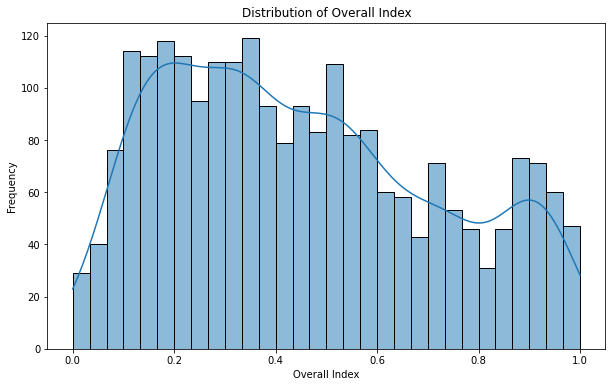

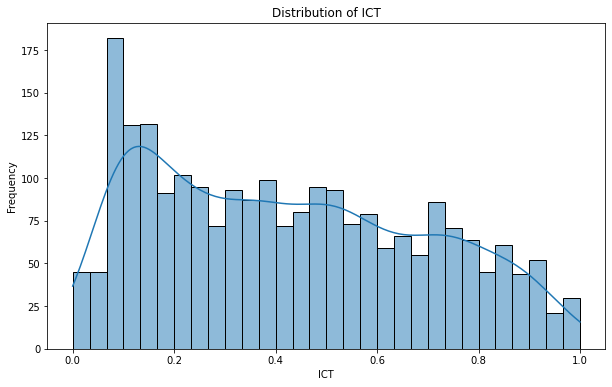

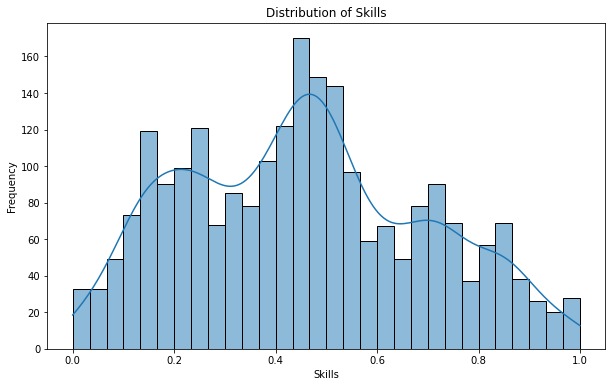

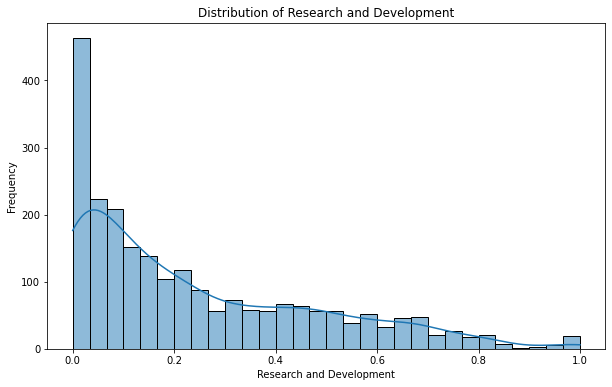

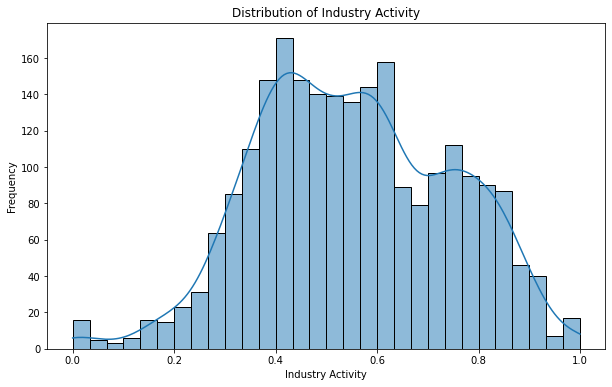

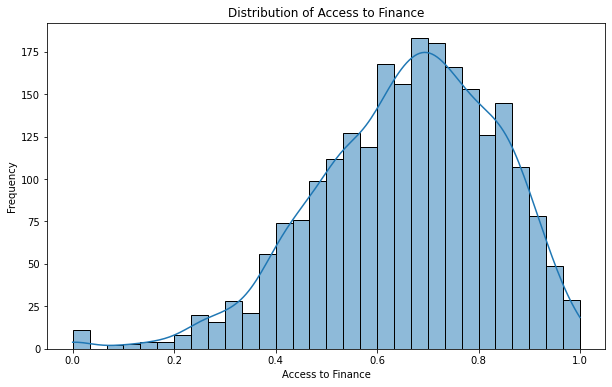

In [165]:
# Plot distribution of Overall Index
plt.figure(figsize=(10, 6))
sns.histplot(gii_pivot['Overall Index'], bins=30, kde=True)
plt.title('Distribution of Overall Index')
plt.xlabel('Overall Index')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of other features
features = ['ICT', 'Skills', 'Research and Development', 'Industry Activity', 'Access to Finance']
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.histplot(gii_pivot[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

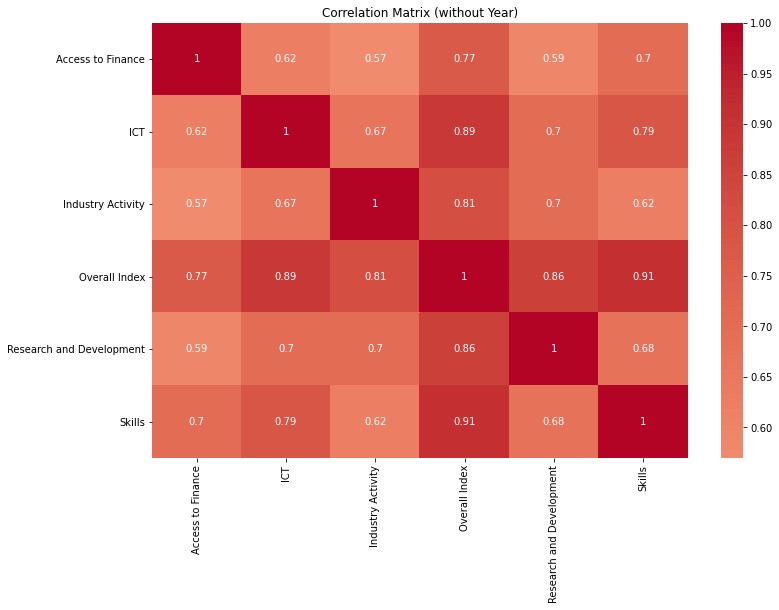

In [166]:
# Remove 'Year' column before calculating the correlation matrix
data_without_year = gii_pivot.drop(columns=['Year'])

# Calculate correlation matrix
correlation_matrix = data_without_year.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (without Year)')
plt.show()

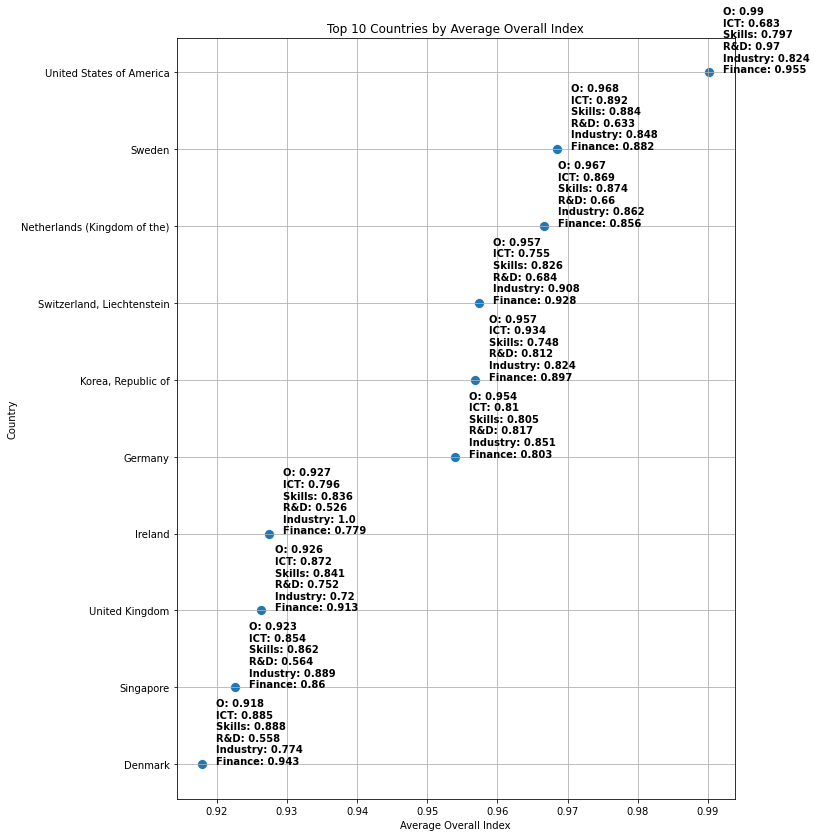

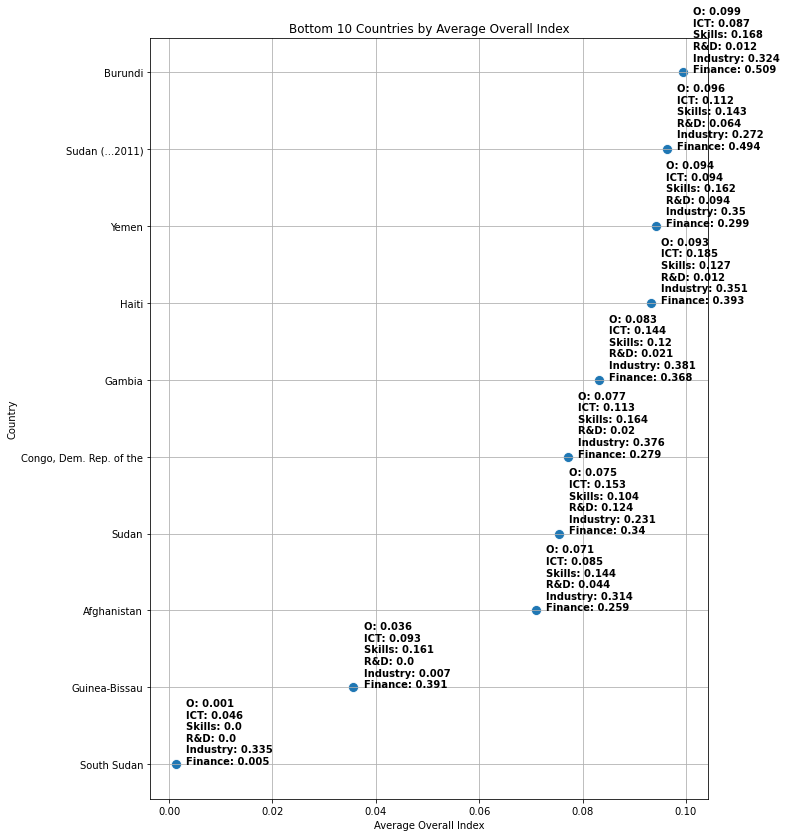

In [167]:
# Convert index columns to numeric, coercing errors to NaN
index_columns = ['Overall Index', 'ICT', 'Skills', 'Research and Development', 'Industry Activity', 'Access to Finance']
for col in index_columns:
    gii_pivot[col] = pd.to_numeric(gii_pivot[col], errors='coerce')
    
# Drop rows with NaN values in any of the index columns after conversion
gii_pivot.dropna(subset=index_columns, inplace=True)

# Calculate the average for each index for each country
average_indices = gii_pivot.groupby('Economy Label')[index_columns].mean().reset_index()

# Sort the data by 'Overall Index'
average_indices = average_indices.sort_values(by='Overall Index', ascending=False)

# Split the data into top 20 and bottom 20 countries
top_10 = average_indices.head(10)
bottom_10 = average_indices.tail(10)

# Function to create scatter plots
def create_scatter_plot(data, title):
    plt.figure(figsize=(10, 14))
    sns.scatterplot(data=data, x='Overall Index', y='Economy Label', s=100, palette='viridis')
    plt.title(title)
    plt.xlabel('Average Overall Index')
    plt.ylabel('Country')
    plt.grid(True)
    
    # Annotate each point with its index values
    for i in range(data.shape[0]):
        plt.text(data['Overall Index'].iloc[i] + 0.002, data['Economy Label'].iloc[i],
                 f"O: {round(data['Overall Index'].iloc[i], 3)}\nICT: {round(data['ICT'].iloc[i], 3)}\n"
                 f"Skills: {round(data['Skills'].iloc[i], 3)}\nR&D: {round(data['Research and Development'].iloc[i], 3)}\n"
                 f"Industry: {round(data['Industry Activity'].iloc[i], 3)}\nFinance: {round(data['Access to Finance'].iloc[i], 3)}",
                 horizontalalignment='left', size='medium', color='black', weight='semibold')
    
    plt.show()

# Create scatter plot for top 20 countries
create_scatter_plot(top_10, 'Top 10 Countries by Average Overall Index')

# Create scatter plot for bottom 20 countries
create_scatter_plot(bottom_10, 'Bottom 10 Countries by Average Overall Index')

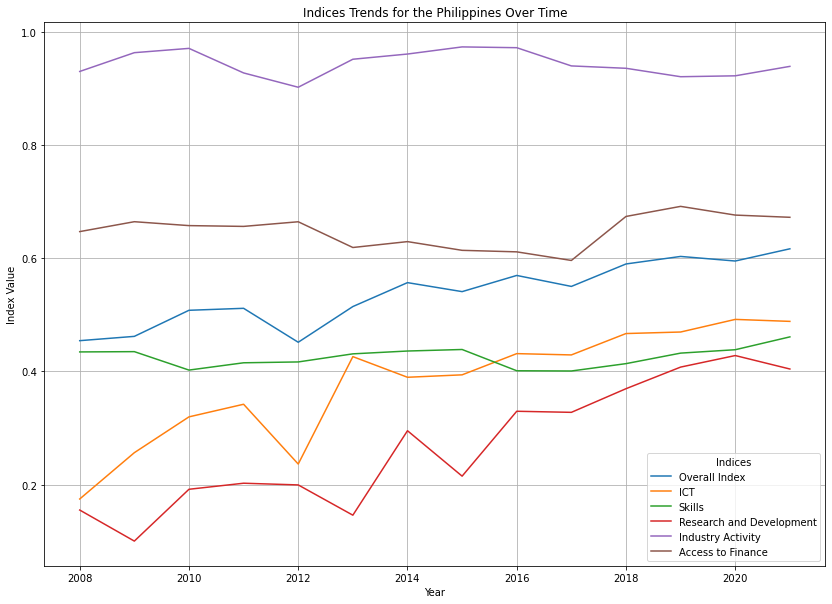

In [168]:
# Filter the data for the Philippines
philippines_data = gii_pivot[gii_pivot['Economy Label'] == 'Philippines']

# Create line plots for each index over the years
plt.figure(figsize=(14, 10))
for col in index_columns:
    sns.lineplot(data=philippines_data, x='Year', y=col, label=col)

plt.title('Indices Trends for the Philippines Over Time')
plt.xlabel('Year')
plt.ylabel('Index Value')
plt.legend(title='Indices')
plt.grid(True)
plt.show()

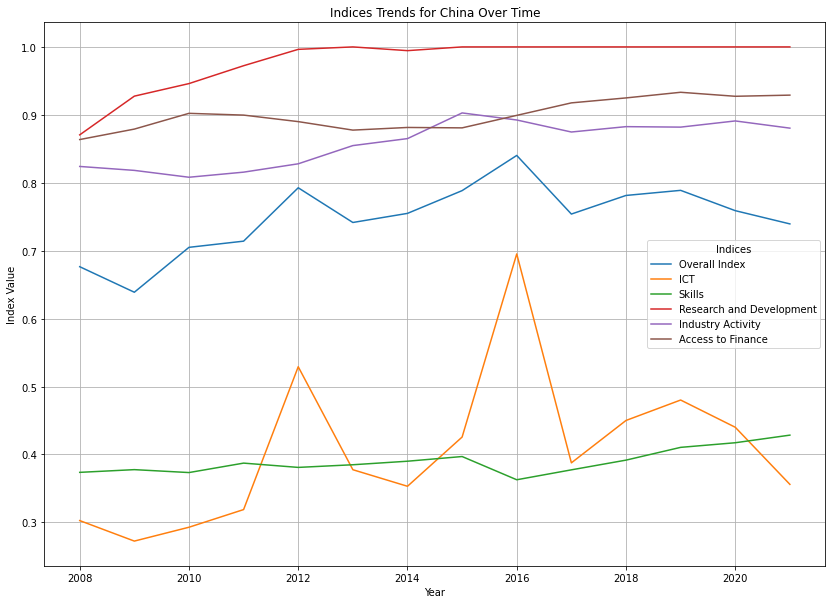

In [169]:
# Filter the data for the China
China_data = gii_pivot[gii_pivot['Economy Label'] == 'China']

# Create line plots for each index over the years
plt.figure(figsize=(14, 10))
for col in index_columns:
    sns.lineplot(data=China_data, x='Year', y=col, label=col)

plt.title('Indices Trends for China Over Time')
plt.xlabel('Year')
plt.ylabel('Index Value')
plt.legend(title='Indices')
plt.grid(True)
plt.show()

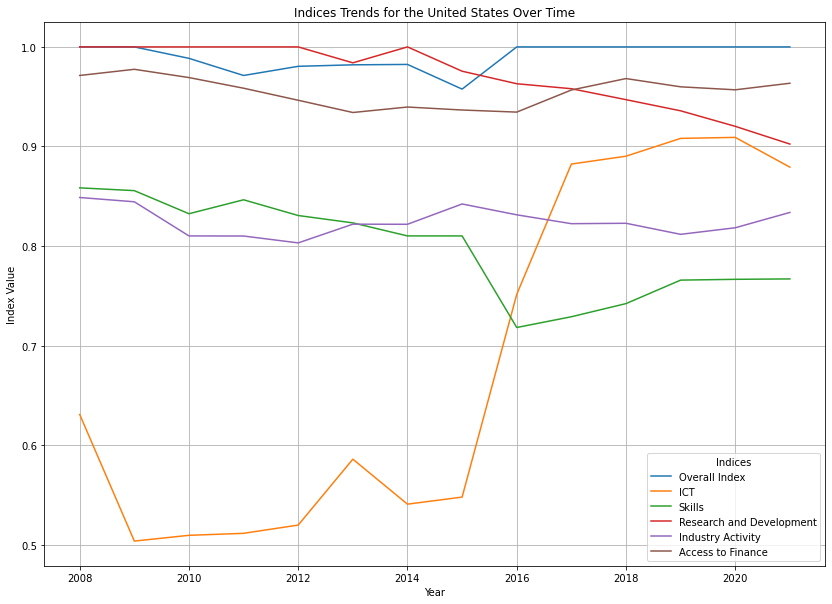

In [170]:
# Filter the data for the United States
USA_data = gii_pivot[gii_pivot['Economy Label'] == 'United States of America']

# Create line plots for each index over the years
plt.figure(figsize=(14, 10))
for col in index_columns:
    sns.lineplot(data=USA_data, x='Year', y=col, label=col)

plt.title('Indices Trends for the United States Over Time')
plt.xlabel('Year')
plt.ylabel('Index Value')
plt.legend(title='Indices')
plt.grid(True)
plt.show()

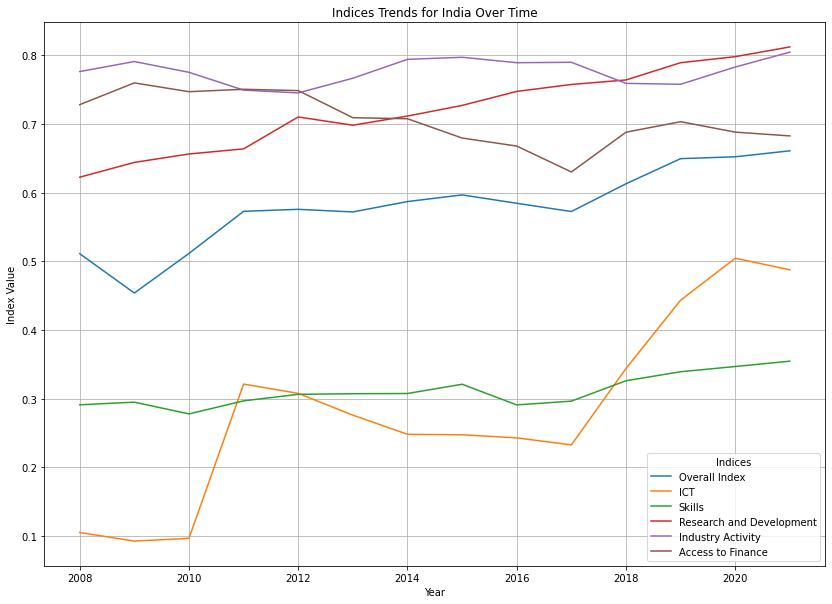

In [171]:
# Filter the data for the India
India_data = gii_pivot[gii_pivot['Economy Label'] == 'India']

# Create line plots for each index over the years
plt.figure(figsize=(14, 10))
for col in index_columns:
    sns.lineplot(data=India_data, x='Year', y=col, label=col)

plt.title('Indices Trends for India Over Time')
plt.xlabel('Year')
plt.ylabel('Index Value')
plt.legend(title='Indices')
plt.grid(True)
plt.show()

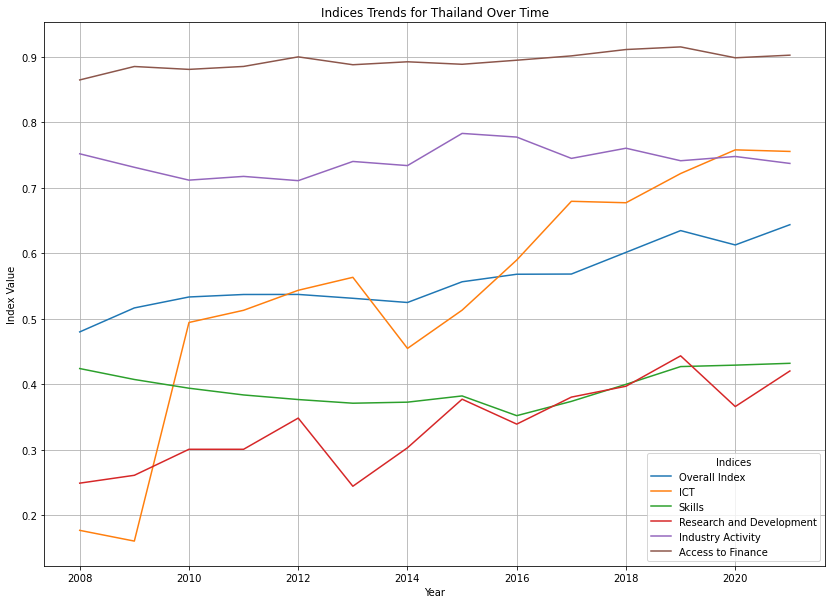

In [172]:
# Filter the data for the Thailand
Thailand_data = gii_pivot[gii_pivot['Economy Label'] == 'Thailand']

# Create line plots for each index over the years
plt.figure(figsize=(14, 10))
for col in index_columns:
    sns.lineplot(data=Thailand_data, x='Year', y=col, label=col)

plt.title('Indices Trends for Thailand Over Time')
plt.xlabel('Year')
plt.ylabel('Index Value')
plt.legend(title='Indices')
plt.grid(True)
plt.show()

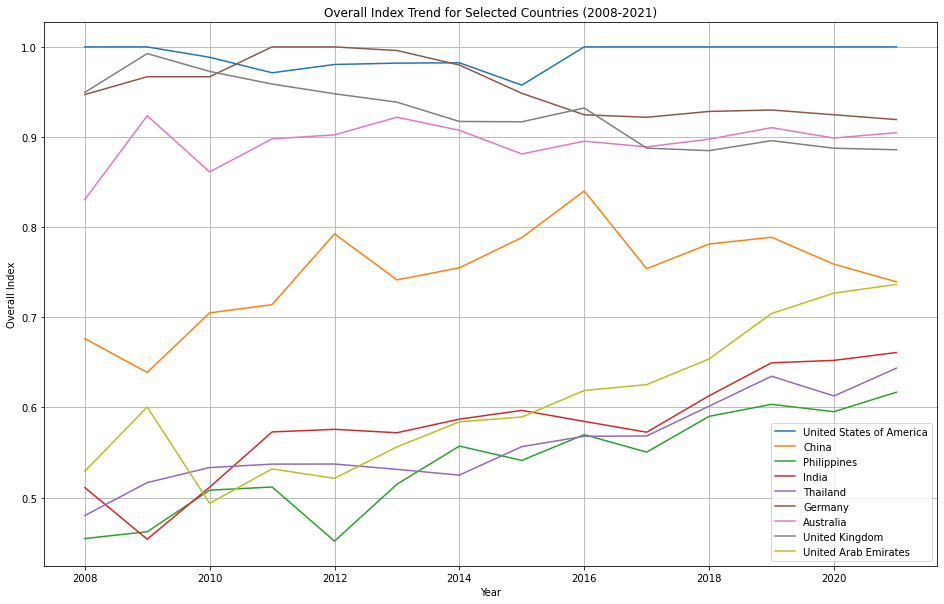

In [173]:
# Plot trends over the years for a few selected countries
selected_countries = ['United States of America', 'China', 'Philippines', 'India', 'Thailand', 'Germany', 'Australia', 'United Kingdom', 'United Arab Emirates']

plt.figure(figsize=(16, 10))
for country in selected_countries:
    country_data = gii_pivot[gii_pivot['Economy Label'] == country]
    plt.plot(country_data['Year'], country_data['Overall Index'], label=country)

plt.title('Overall Index Trend for Selected Countries (2008-2021)')
plt.xlabel('Year')
plt.ylabel('Overall Index')
plt.legend()
plt.grid(True)
plt.show()

In [174]:
# Calculate the thresholds based on quantiles
thresholds = gii_pivot_imputed['Overall Index'].quantile([0.3333, 0.6666])

beginner_threshold = thresholds.iloc[0]
intermediate_threshold = thresholds.iloc[1]

# Function to categorize the overall index
def categorize_overall_index(index):
    if index <= beginner_threshold:
        return 'Beginner'
    elif index <= intermediate_threshold:
        return 'Intermediate'
    else:
        return 'Advanced'

# Apply the function to create a new categorical column
gii_pivot_imputed['Overall Index'] = gii_pivot_imputed['Overall Index'].apply(categorize_overall_index)

# Verify the distribution of the categories
category_distribution = gii_pivot_imputed['Overall Index'].value_counts()
print("Category distribution:\n", category_distribution)

Category distribution:
 Series([], Name: Overall Index, dtype: int64)


In [175]:
# Define features and target
features = ['Year', 'Economy Label', 'ICT', 'Skills', 'Research and Development', 'Industry Activity', 'Access to Finance']
target = 'Overall Index'

# Filter the dataset for the selected features and target
feature_data = gii_pivot_imputed[features].copy()
target_data = gii_pivot_imputed[target].copy()

# Check the shape of feature_data and target_data
print("Shape of feature_data:", feature_data.shape)
print("Shape of target_data:", target_data.shape)

# Check the first few rows to ensure data is correctly populated
print("First few rows of feature_data:")
print(feature_data.head())

print("First few rows of target_data:")
print(target_data.head())

Shape of feature_data: (0, 7)
Shape of target_data: (0,)
First few rows of feature_data:
Empty DataFrame
Columns: [Year, Economy Label, ICT, Skills, Research and Development, Industry Activity, Access to Finance]
Index: []
First few rows of target_data:
Series([], Name: Overall Index, dtype: float64)


In [176]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Define the model pipeline for Logistic Regression
logistic_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train the Logistic Regression model
logistic_model.fit(X_train, y_train)

# Predict and evaluate the Logistic Regression model
y_pred_logistic = logistic_model.predict(X_test)
logistic_report = classification_report(y_test, y_pred_logistic, output_dict=True)

# Convert the classification report to a DataFrame
logistic_report_df = pd.DataFrame(logistic_report).transpose()
print("Logistic Regression Classification Report")
print(logistic_report_df)

Logistic Regression Classification Report
              precision    recall  f1-score     support
Advanced       0.961538  0.969828  0.965665  232.000000
Beginner       0.960352  0.939655  0.949891  232.000000
Intermediate   0.910638  0.922414  0.916488  232.000000
accuracy       0.943966  0.943966  0.943966    0.943966
macro avg      0.944176  0.943966  0.944015  696.000000
weighted avg   0.944176  0.943966  0.944015  696.000000


In [177]:
from sklearn.neighbors import KNeighborsClassifier

# Define the model pipeline for kNN
knn_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Train the kNN model
knn_model.fit(X_train, y_train)

# Predict and evaluate the kNN model
y_pred_knn = knn_model.predict(X_test)
knn_report = classification_report(y_test, y_pred_knn, output_dict=True)

# Convert the classification report to a DataFrame
knn_report_df = pd.DataFrame(knn_report).transpose()
print("kNN Classification Report")
print(knn_report_df)

kNN Classification Report
              precision    recall  f1-score     support
Advanced       0.945148  0.965517  0.955224  232.000000
Beginner       0.959641  0.922414  0.940659  232.000000
Intermediate   0.889831  0.905172  0.897436  232.000000
accuracy       0.931034  0.931034  0.931034    0.931034
macro avg      0.931540  0.931034  0.931106  696.000000
weighted avg   0.931540  0.931034  0.931106  696.000000


In [178]:
from sklearn.tree import DecisionTreeClassifier

# Define the model pipeline for Decision Tree
dt_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Train the Decision Tree model
dt_model.fit(X_train, y_train)

# Predict and evaluate the Decision Tree model
y_pred_dt = dt_model.predict(X_test)
dt_report = classification_report(y_test, y_pred_dt, output_dict=True)

# Convert the classification report to a DataFrame
dt_report_df = pd.DataFrame(dt_report).transpose()
print("Decision Tree Classification Report")
print(dt_report_df)

Decision Tree Classification Report
              precision    recall  f1-score     support
Advanced       0.921488  0.961207  0.940928  232.000000
Beginner       0.911017  0.926724  0.918803  232.000000
Intermediate   0.880734  0.827586  0.853333  232.000000
accuracy       0.905172  0.905172  0.905172    0.905172
macro avg      0.904413  0.905172  0.904355  696.000000
weighted avg   0.904413  0.905172  0.904355  696.000000


In [179]:
from sklearn.ensemble import RandomForestClassifier

# Define the model pipeline for Random Forest
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Predict and evaluate the Random Forest model
y_pred_rf = rf_model.predict(X_test)
rf_report = classification_report(y_test, y_pred_rf, output_dict=True)

# Convert the classification report to a DataFrame
rf_report_df = pd.DataFrame(rf_report).transpose()
print("Random Forest Classification Report")
print(rf_report_df)

Random Forest Classification Report
              precision    recall  f1-score     support
Advanced       0.938017  0.978448  0.957806  232.000000
Beginner       0.951965  0.939655  0.945770  232.000000
Intermediate   0.915556  0.887931  0.901532  232.000000
accuracy       0.935345  0.935345  0.935345    0.935345
macro avg      0.935179  0.935345  0.935036  696.000000
weighted avg   0.935179  0.935345  0.935036  696.000000


In [180]:
# Summary of model metrics
summary_data = {
    'Model': ['Logistic Regression', 'kNN', 'Decision Tree', 'Random Forest'],
    'Accuracy': [0.944, 0.931, 0.905, 0.935],
    'Precision (Macro Avg)': [0.9442, 0.9315, 0.9044, 0.9352],
    'Recall (Macro Avg)': [0.9440, 0.9310, 0.9052, 0.9353],
    'F1-Score (Macro Avg)': [0.9440, 0.9311, 0.9044, 0.9350]
}

# Create a DataFrame for the summary
summary_df = pd.DataFrame(summary_data)

# Display the summary
print(summary_df)

                 Model  Accuracy  Precision (Macro Avg)  Recall (Macro Avg)  \
0  Logistic Regression     0.944                 0.9442              0.9440   
1                  kNN     0.931                 0.9315              0.9310   
2        Decision Tree     0.905                 0.9044              0.9052   
3        Random Forest     0.935                 0.9352              0.9353   

   F1-Score (Macro Avg)  
0                0.9440  
1                0.9311  
2                0.9044  
3                0.9350  


In [181]:
# Perform cross-validation to evaluate the model
cross_val_scores = cross_val_score(logistic_model, feature_data, target_data, cv=5, scoring='accuracy')

print("Cross-Validation Scores: ", cross_val_scores)
print("Mean Cross-Validation Score: ", cross_val_scores.mean())
print("Standard Deviation of Cross-Validation Scores: ", cross_val_scores.std())

# Example new data points (replace these with actual new data as needed)
new_data = pd.DataFrame({
    'Year': [2022, 2023],
    'Economy Label': ['Country A', 'Country B'],
    'ICT': [0.8, 0.6],
    'Skills': [0.7, 0.5],
    'Research and Development': [0.6, 0.7],
    'Industry Activity': [0.5, 0.4],
    'Access to Finance': [0.7, 0.6]
})

# Preprocess the new data using the same preprocessing pipeline
new_data_preprocessed = preprocessor.transform(new_data)

# Make predictions using the trained model
new_predictions = logistic_model.predict(new_data_preprocessed)

print("New Data Predictions: ", new_predictions)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

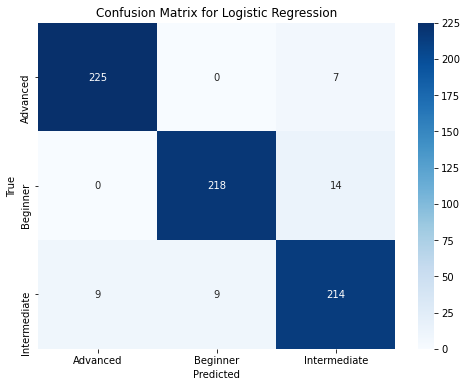

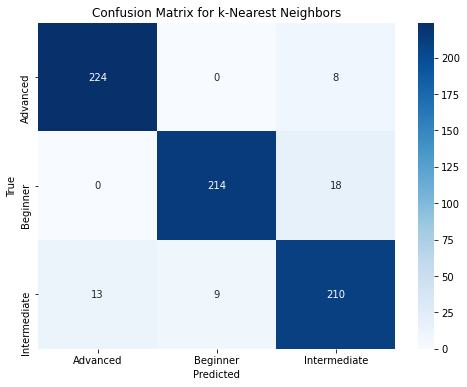

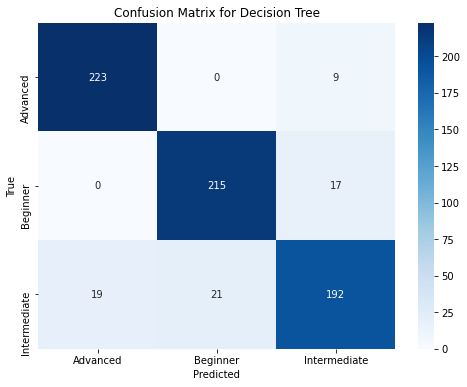

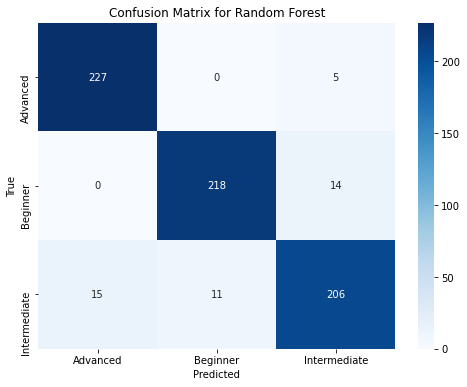

In [182]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=logistic_model.named_steps['classifier'].classes_, yticklabels=logistic_model.named_steps['classifier'].classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Logistic Regression Confusion Matrix
y_pred_logistic = logistic_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred_logistic, "Logistic Regression")

# kNN Confusion Matrix
y_pred_knn = knn_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred_knn, "k-Nearest Neighbors")

# Decision Tree Confusion Matrix
y_pred_dt = dt_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred_dt, "Decision Tree")

# Random Forest Confusion Matrix
y_pred_rf = rf_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")

In [184]:
# LIME explanation
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_transformed,
    feature_names=numerical_features,
    class_names=random_forest_model.named_steps['classifier'].classes_,
    mode='classification'
)

instance_idx = 0
instance = X_test_transformed[instance_idx].reshape(1, -1)
exp = explainer_lime.explain_instance(
    data_row=instance[0],
    predict_fn=random_forest_model.predict_proba
)
exp.show_in_notebook(show_table=True)

# SHAP explanation
explainer_shap = shap.TreeExplainer(random_forest_model.named_steps['classifier'])
shap_values = explainer_shap.shap_values(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, plot_type='bar')

instance_idx = 0
instance = X_test_transformed[instance_idx]
shap.initjs()
shap.force_plot(explainer_shap.expected_value, shap_values[instance_idx], instance)

ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.